In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import os
import random
import numpy as np
import pandas as pd
import xgboost as xgb
from FRUFS import FRUFS
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from scipy.stats import skew, kurtosis

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

SEED = 721991

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)    
    tf.random.set_seed(seed)

In [2]:
# Reading the data
df_train = pd.read_csv('./train_features.csv')
df_test = pd.read_csv('./test_features.csv')
df_train_targets_scored = pd.read_csv('./train_targets_scored.csv')
df_train_targets_nonscored = pd.read_csv('./train_targets_nonscored.csv')
df_test_targets = pd.read_csv('./sample_submission.csv')

# Identifying target features
target_features_scored = list(df_train_targets_scored.columns[1:])
target_features_nonscored = list(df_train_targets_nonscored.columns[1:])

# Identifying columns to retain that have at least 2 non-zero entries
columns_to_retain_nonscored = [col for col in df_train_targets_nonscored.columns if (df_train_targets_nonscored[col] != 0).sum() >= 0]

# Selecting only the retained columns
df_train_targets_nonscored = df_train_targets_nonscored[columns_to_retain_nonscored]

# Updating the list of target features for nonscored targets
target_features_nonscored = [col for col in columns_to_retain_nonscored if col != 'sig_id']  # Assuming 'sig_id' is not a target feature

# Type conversion for optimization
df_train_targets_scored[target_features_scored] = df_train_targets_scored[target_features_scored].astype(np.uint8)
df_train_targets_nonscored[target_features_nonscored] = df_train_targets_nonscored[target_features_nonscored].astype(np.uint8)
df_test_targets[target_features_scored] = df_test_targets[target_features_scored].astype(np.float32)


In [3]:
df_train = df_train.merge(df_train_targets_scored, on='sig_id', how='left')
# df_train = df_train.merge(df_train_targets_nonscored, on='sig_id', how='left')
df_test = df_test.merge(df_test_targets, on='sig_id', how='left')

print(f'Training Set Shape = {df_train.shape}')
print(f'Training Set Memory Usage = {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')
print(f'Test Set Shape = {df_test.shape}')
print(f'Test Set Memory Usage = {df_test.memory_usage().sum() / 1024 ** 2:.2f} MB')

Training Set Shape = (23814, 1082)
Training Set Memory Usage = 163.84 MB
Test Set Shape = (3982, 1082)
Test Set Memory Usage = 29.74 MB


In [4]:
df_train.head()
# sig_id is the unique sample id
# Features with g- prefix are gene expression features and there are 772 of them (from g-0 to g-771)
# Features with c- prefix are cell viability features and there are 100 of them (from c-0 to c-99)
# cp_type is a binary categorical feature which indicates the samples are treated with a compound or with a control perturbation (trt_cp or ctl_vehicle)
# cp_time is a categorical feature which indicates the treatment duration (24, 48 or 72 hours)
# cp_dose is a binary categorical feature which indicates the dose is low or high (D1 or D2)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,g-40,g-41,g-42,g-43,g-44,g-45,g-46,g-47,g-48,g-49,g-50,g-51,g-52,g-53,g-54,g-55,g-56,g-57,g-58,g-59,g-60,g-61,g-62,g-63,g-64,g-65,g-66,g-67,g-68,g-69,g-70,g-71,g-72,g-73,g-74,g-75,g-76,g-77,g-78,g-79,g-80,g-81,g-82,g-83,g-84,g-85,g-86,g-87,g-88,g-89,g-90,g-91,g-92,g-93,g-94,g-95,g-96,g-97,g-98,g-99,g-100,g-101,g-102,g-103,g-104,g-105,g-106,g-107,g-108,g-109,g-110,g-111,g-112,g-113,g-114,g-115,g-116,g-117,g-118,g-119,g-120,g-121,g-122,g-123,g-124,g-125,g-126,g-127,g-128,g-129,g-130,g-131,g-132,g-133,g-134,g-135,g-136,g-137,g-138,g-139,g-140,g-141,g-142,g-143,g-144,g-145,g-146,g-147,g-148,g-149,g-150,g-151,g-152,g-153,g-154,g-155,g-156,g-157,g-158,g-159,g-160,g-161,g-162,g-163,g-164,g-165,g-166,g-167,g-168,g-169,g-170,g-171,g-172,g-173,g-174,g-175,g-176,g-177,g-178,g-179,g-180,g-181,g-182,g-183,g-184,g-185,g-186,g-187,g-188,g-189,g-190,g-191,g-192,g-193,g-194,g-195,g-196,g-197,g-198,g-199,g-200,g-201,g-202,g-203,g-204,g-205,g-206,g-207,g-208,g-209,g-210,g-211,g-212,g-213,g-214,g-215,g-216,g-217,g-218,g-219,g-220,g-221,g-222,g-223,g-224,g-225,g-226,g-227,g-228,g-229,g-230,g-231,g-232,g-233,g-234,g-235,g-236,g-237,g-238,g-239,g-240,g-241,g-242,g-243,g-244,g-245,...,c-56,c-57,c-58,c-59,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,autotaxin_inhibitor,bacterial_30s_ribosomal_subunit_inhibitor,bacterial_50s_ribosomal_subunit_inhibitor,bacterial_antifolate,bacterial_cell_wall_synthesis_inhibitor,bacterial_dna_gyrase_inhibitor,bacterial_dna_inhibitor,bacterial_membrane_integrity_inhibitor,bcl_inhibitor,bcr-abl_inhibitor,benzodiazepine_receptor_agonist,beta_amyloid_inhibitor,bromodomain_inhibitor,btk_inhibitor,calcineurin_inhibitor,calcium_channel_blocker,cannabinoid_receptor_agonist,cannabinoid_receptor_antagonist,carbonic_anhydrase_inhibitor,casein_kinase_inhibitor,caspase_activator,catechol_o_methyltransferase_inhibitor,cc_chemokine_receptor_antagonist,cck_receptor_antagonist,cdk_inhibitor,chelating_agent,chk_inhibitor,chloride_channel_blocker,cholesterol_inhibitor,cholinergic_receptor_antagonist,coagulation_factor_inhibitor,corticosteroid_agonist,cyclooxygenase_inhibitor,cytochrome_p450_inhibitor,dihydrofolate_reductase_inhibitor,dipeptidyl_peptidase_inhibitor,diuretic,dna_alkylating_agent,dna_inhibitor,dopamine_receptor_agonist,dopamine_receptor_antagonist,egfr_inhibitor,elastase_inhibitor,erbb2_inhibitor,estrogen_receptor_agonist,estrogen_receptor_antagonist,faah_inhibitor,farnesyltransferase_inhibitor,fatty_acid_receptor_agonist,fgfr_inhibitor,flt3_inhibitor,focal_adhesion_kinase_inhibitor,free_radical_scavenger,fungal_squalene_epoxidase_inhibitor,gaba_receptor_agonist,gaba_receptor_antagonist,gamma_secretase_inhibitor,glucocorticoid_receptor_agonist,glutamate_inhibitor,glutamate_receptor_agonist,glutamate_receptor_antagonist,gonadotro

In [5]:
g_features = [feature for feature in df_train.columns if feature.startswith('g-')]
c_features = [feature for feature in df_train.columns if feature.startswith('c-')]
other_features = [feature for feature in df_train.columns if feature not in g_features and 
                                                             feature not in c_features and 
                                                             feature not in target_features_scored and
                                                             feature not in target_features_nonscored]

print(f'Number of g- Features: {len(g_features)}')
print(f'Number of c- Features: {len(c_features)}')
print(f'Number of Other Features: {len(other_features)} ({other_features})')

Number of g- Features: 772
Number of c- Features: 100
Number of Other Features: 4 (['sig_id', 'cp_type', 'cp_time', 'cp_dose'])


In [6]:
# check for any NA Values
df_train.isna().sum().sum()

0

## Dataset Operations

In [7]:
df_train

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,g-40,g-41,g-42,g-43,g-44,g-45,g-46,g-47,g-48,g-49,g-50,g-51,g-52,g-53,g-54,g-55,g-56,g-57,g-58,g-59,g-60,g-61,g-62,g-63,g-64,g-65,g-66,g-67,g-68,g-69,g-70,g-71,g-72,g-73,g-74,g-75,g-76,g-77,g-78,g-79,g-80,g-81,g-82,g-83,g-84,g-85,g-86,g-87,g-88,g-89,g-90,g-91,g-92,g-93,g-94,g-95,g-96,g-97,g-98,g-99,g-100,g-101,g-102,g-103,g-104,g-105,g-106,g-107,g-108,g-109,g-110,g-111,g-112,g-113,g-114,g-115,g-116,g-117,g-118,g-119,g-120,g-121,g-122,g-123,g-124,g-125,g-126,g-127,g-128,g-129,g-130,g-131,g-132,g-133,g-134,g-135,g-136,g-137,g-138,g-139,g-140,g-141,g-142,g-143,g-144,g-145,g-146,g-147,g-148,g-149,g-150,g-151,g-152,g-153,g-154,g-155,g-156,g-157,g-158,g-159,g-160,g-161,g-162,g-163,g-164,g-165,g-166,g-167,g-168,g-169,g-170,g-171,g-172,g-173,g-174,g-175,g-176,g-177,g-178,g-179,g-180,g-181,g-182,g-183,g-184,g-185,g-186,g-187,g-188,g-189,g-190,g-191,g-192,g-193,g-194,g-195,g-196,g-197,g-198,g-199,g-200,g-201,g-202,g-203,g-204,g-205,g-206,g-207,g-208,g-209,g-210,g-211,g-212,g-213,g-214,g-215,g-216,g-217,g-218,g-219,g-220,g-221,g-222,g-223,g-224,g-225,g-226,g-227,g-228,g-229,g-230,g-231,g-232,g-233,g-234,g-235,g-236,g-237,g-238,g-239,g-240,g-241,g-242,g-243,g-244,g-245,...,c-56,c-57,c-58,c-59,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,autotaxin_inhibitor,bacterial_30s_ribosomal_subunit_inhibitor,bacterial_50s_ribosomal_subunit_inhibitor,bacterial_antifolate,bacterial_cell_wall_synthesis_inhibitor,bacterial_dna_gyrase_inhibitor,bacterial_dna_inhibitor,bacterial_membrane_integrity_inhibitor,bcl_inhibitor,bcr-abl_inhibitor,benzodiazepine_receptor_agonist,beta_amyloid_inhibitor,bromodomain_inhibitor,btk_inhibitor,calcineurin_inhibitor,calcium_channel_blocker,cannabinoid_receptor_agonist,cannabinoid_receptor_antagonist,carbonic_anhydrase_inhibitor,casein_kinase_inhibitor,caspase_activator,catechol_o_methyltransferase_inhibitor,cc_chemokine_receptor_antagonist,cck_receptor_antagonist,cdk_inhibitor,chelating_agent,chk_inhibitor,chloride_channel_blocker,cholesterol_inhibitor,cholinergic_receptor_antagonist,coagulation_factor_inhibitor,corticosteroid_agonist,cyclooxygenase_inhibitor,cytochrome_p450_inhibitor,dihydrofolate_reductase_inhibitor,dipeptidyl_peptidase_inhibitor,diuretic,dna_alkylating_agent,dna_inhibitor,dopamine_receptor_agonist,dopamine_receptor_antagonist,egfr_inhibitor,elastase_inhibitor,erbb2_inhibitor,estrogen_receptor_agonist,estrogen_receptor_antagonist,faah_inhibitor,farnesyltransferase_inhibitor,fatty_acid_receptor_agonist,fgfr_inhibitor,flt3_inhibitor,focal_adhesion_kinase_inhibitor,free_radical_scavenger,fungal_squalene_epoxidase_inhibitor,gaba_receptor_agonist,gaba_receptor_antagonist,gamma_secretase_inhibitor,glucocorticoid_receptor_agonist,glutamate_inhibitor,glutamate_receptor_agonist,glutamate_receptor_antagonist,gonadotro

In [8]:
# # # PCA karo?
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# c_features = [feature for feature in df_train.columns if feature.startswith('c-')]
# g_features = [feature for feature in df_train.columns if feature.startswith('g-')]
# selected_g_features = ['g-37', 'g-50', 'g-672', 'g-489', 'g-349', 'g-460', 'g-569', 'g-369', 'g-123', 'g-744', 'g-195', 'g-63', 'g-121', 'g-410', 'g-248', 'g-228', 'g-38', 'g-72', 'g-760', 'g-261', 'g-417', 'g-328', 'g-406', 'g-257']


# scaler = StandardScaler()
# c_features_scaled = scaler.fit_transform(df_train[c_features])
# g_features_scaled = scaler.fit_transform(df_train[selected_g_features])

# pca = PCA(n_components=5)
# c_features_pca = pca.fit_transform(c_features_scaled)
# g_features_pca = pca.fit_transform(g_features_scaled)

# # Drop original 'c' features
# df_train = df_train.drop(c_features, axis=1)
# # Create a DataFrame for the PCA components
# c_features_pca_df = pd.DataFrame(c_features_pca, columns=['c_pc1', 'c_pc2', 'c_pc3', 'c_pc4', 'c_pc5'])
# # Concatenate the PCA components with the original DataFrame
# df_train = pd.concat([df_train, c_features_pca_df], axis=1)
# #
# # # Drop original 'g' features
# df_train = df_train.drop(selected_g_features, axis=1)
# # Create a DataFrame for the PCA components
# g_features_pca_df = pd.DataFrame(g_features_pca, columns=['g_pc1', 'g_pc2', 'g_pc3', 'g_pc4', 'g_pc5'])
# # Concatenate the PCA components with the original DataFrame
# df_train = pd.concat([df_train, g_features_pca_df], axis=1)


# c_features = [feature for feature in df_train.columns if feature.startswith('c_pc')]
# g_features = [feature for feature in g_features if feature not in selected_g_features]
# g_features += ['g_pc1', 'g_pc2', 'g_pc3', 'g_pc4', 'g_pc5']

In [9]:
# Shuffle the dataset
df_train = shuffle(df_train, random_state=42)

# Drop the 'sig_id' column
df_train = df_train.drop('sig_id', axis=1)

# One-hot encoding for 'cp_type', 'cp_time', 'cp_dose'
one_hot_encoder = OneHotEncoder(sparse=False)
cp_time_encoder = LabelEncoder()
cp_dose_encoder = LabelEncoder()

encoded_columns = one_hot_encoder.fit_transform(df_train[['cp_type']])
column_names = one_hot_encoder.get_feature_names_out(['cp_type'])

df_train['cp_time'] = cp_time_encoder.fit_transform(df_train['cp_time'])
df_train['cp_dose'] = cp_dose_encoder.fit_transform(df_train['cp_dose'])

# Create a DataFrame with the encoded columns
encoded_df = pd.DataFrame(encoded_columns, columns=column_names)

c:\Users\chopr\anaconda3\envs\part-time\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [10]:
# Drop original columns and concat the new encoded columns
df_train = df_train.drop(['cp_type'], axis=1)
df_train = pd.concat([df_train, encoded_df], axis=1)

In [11]:
# Identify the one-hot encoded features for cp_type, cp_time, and cp_dose
one_hot_features = [feature for feature in df_train.columns if feature.startswith('cp_type_')]

# Combine all feature lists to create the X dataset
feature_columns = g_features + c_features + one_hot_features + ['cp_time', 'cp_dose']
X = df_train[feature_columns]

# For Y, use the columns that are not in the features list
Y = df_train.drop(feature_columns, axis=1)

print(f'Number of g- Features: {len(g_features)}')
print(f'Number of c- Features: {len(c_features)}')
print(f'Number of One Hot Features: {len(one_hot_features)} ({one_hot_features})')


Number of g- Features: 753
Number of c- Features: 5
Number of One Hot Features: 2 (['cp_type_ctl_vehicle', 'cp_type_trt_cp'])


In [12]:
from skmultilearn.model_selection import iterative_train_test_split

# Store the column names before the split
X_columns = X.columns
Y_columns = Y.columns

# Perform the split with numpy arrays
X_np, Y_np, X_test_orig_np, y_test_orig_np = iterative_train_test_split(X.values, Y.values, test_size=0.2)

# Convert numpy arrays back to pandas DataFrames
X = pd.DataFrame(X_np, columns=X_columns)
Y = pd.DataFrame(Y_np, columns=Y_columns)

X_test_orig = pd.DataFrame(X_test_orig_np, columns=X_columns)
y_test_orig = pd.DataFrame(y_test_orig_np, columns=Y_columns)

In [13]:
def get_tail_label(df: pd.DataFrame, ql=[0.05, 1.]) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    """
    irlbl = df.sum(axis=0)
    irlbl = irlbl[(irlbl > irlbl.quantile(ql[0])) & ((irlbl < irlbl.quantile(ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = irlbl.median()
    tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()
    return tail_label

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    tail_labels = get_tail_label(y, ql=ql)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    """
    Give index of 10 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_sample, neigh=5, categorical_features=[]):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    categorical_features: list, list of categorical feature names
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)

        # Handle categorical features
        for feature in categorical_features:
            mode_value = X.loc[all_point, feature].mode()
            if mode_value.empty:  # If mode cannot be computed (all values are different)
                mode_value = [X.loc[reference, feature]]  # Use the value of the reference sample
            new_X[i, X.columns.get_loc(feature)] = mode_value[0]

    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

# X_sub, y_sub = get_minority_samples(X, Y)  # Getting minority samples of that datframe
# X_res, y_res = MLSMOTE(X_sub, y_sub, 2000, 5)  # Applying MLSMOTE to augment the dataframe

In [14]:
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.neighbors import NearestNeighbors
# 1. Use it on only a subset of X, which has only g_features + c_features
# Apply MLSMOTE on continuous features
# X_sub = X
X_sub, y_sub = get_minority_samples(X, Y)  # Getting minority samples of that dataframe
X_res, y_res = MLSMOTE(X_sub, y_sub, X.shape[0], 5, categorical_features=['cp_type_ctl_vehicle','cp_type_trt_cp','cp_time','cp_dose'])  # Applying MLSMOTE to augment the dataframe

In [15]:
Y['acat_inhibitor'].value_counts()

acat_inhibitor
0    19032
1       19
Name: count, dtype: int64

In [16]:
y_res['acat_inhibitor'].value_counts()

acat_inhibitor
0.0    18618
1.0      433
Name: count, dtype: int64

## Basline ML model

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from math import sqrt


X = X_res
Y = y_res
# Separate the DataFrame into continuous and one-hot encoded features
X_continuous = X[g_features + c_features+ ['cp_time', 'cp_dose']] 
X_one_hot = X[one_hot_features]

# Scale the continuous features
scaler = StandardScaler()
X_continuous_scaled = scaler.fit_transform(X_continuous)

# Combine the scaled continuous features and one-hot encoded features
X_scaled = np.concatenate([X_continuous_scaled, X_one_hot], axis=1)

# Verify that X and X_scaled have the same dimensions
print(X_scaled.shape == X.shape)


True


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

n_features = Y.shape[1]
# split Y into train and test
Y_original_train, Y_original_test = train_test_split(Y, test_size=0.2, random_state=8)

# trying to reduce the output features using autoencoders
input_layer = Input(shape=(n_features,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(10, activation='relu')(encoded)  # Encoded representation

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(n_features, activation='sigmoid')(decoded)  # Reconstruction
# autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)
# Compile
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
# Summary
autoencoder.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 206)]             0         
                                                                 
 dense (Dense)               (None, 128)               26496     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
 dense_2 (Dense)             (None, 64)                704       
                                                                 
 dense_3 (Dense)             (None, 206)               13390     
                                                                 
Total params: 41880 (163.59 KB)
Trainable params: 41880 (163.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
random.seed(1)
autoencoder.fit(Y_original_train, Y_original_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(Y_original_test, Y_original_test))

Epoch 1/50

60/60 [==============================] - 1s 7ms/step - loss: 0.4170 - val_loss: 0.1154
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.1012 - val_loss: 0.0949
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.0929 - val_loss: 0.0901
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 0.0872 - val_loss: 0.0829
Epoch 5/50
60/60 [==============================] - 0s 3ms/step - loss: 0.0794 - val_loss: 0.0755
Epoch 6/50
60/60 [==============================] - 0s 2ms/step - loss: 0.0721 - val_loss: 0.0684
Epoch 7/50
60/60 [==============================] - 0s 2ms/step - loss: 0.0649 - val_loss: 0.0614
Epoch 8/50
60/60 [==============================] - 0s 2ms/step - loss: 0.0588 - val_loss: 0.0564
Epoch 9/50
60/60 [==============================] - 0s 3ms/step - loss: 0.0544 - val_loss: 0.0526
Epoch 10/50
60/60 [==============================] - 0s 3ms/step - loss: 0.0510 - val_loss: 0.0494
Epoch 11/50
60/60 

In [20]:
# X_scaled_np = X_scaled.values
# Y_np = Y.values
# Split data
# X_train, y_train, X_test, y_test = iterative_train_test_split(X_scaled, Y.to_numpy(), test_size=0.1)
# X_train, y_train, X_test, y_test = iterative_train_test_split(X_scaled, Y_encoded, test_size=0.1)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Example of checking the format of y_train
print(y_train.shape)  # Should be (n_samples, n_labels)

(15240, 206)


In [21]:
# encoder model
encoder = Model(inputs=input_layer, outputs=encoded)
# Get the 20-dimensional encoded representation
Y_encoded = encoder.predict(y_train)

477/477 [==============================] - 0s 684us/step


In [22]:
column_sums = Y_encoded.sum(axis=0)
print(column_sums)

[136035.08  157393.05  111700.53  113975.984 111981.875 121164.89
 101577.46  123738.94  138699.19  144272.03 ]


In [23]:
import gc

# Delete variables
del X, Y, X_sub, y_sub, X_res, y_res
gc.collect()

1708

In [24]:
params = {'estimator__colsample_bytree': 0.6522,
          'estimator__gamma': 3.6975,
          'estimator__learning_rate': 0.0503,
          'estimator__max_delta_step': 2.0706,
          'estimator__max_depth': 10,
          'estimator__min_child_weight': 31.5800,
          'estimator__n_estimators': 166,
          'estimator__subsample': 0.8639
         }


# Model
# model = MultiOutputClassifier(LogisticRegression()) # F1 Score = 0.25655
# # model = MultiOutputClassifier(LogisticRegression()) # F1 Score = 0.1456 (with PCA, on both c and g features)
# # model = MultiOutputClassifier(xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')) # F1 Score = 0.2747
# model = MultiOutputClassifier(xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')) # F1 Score = 0.1931 (both cells and genes PCA)
# model = MultiOutputClassifier(xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')) # F1 Score = 0.2622 (only cells PCA)
model = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror', eval_metric='logloss')) # F1 Score = 0.1697 (only cells PCA)
model.set_params(**params)

model.fit(X_train, Y_encoded)

# Make predictions
y_pred = model.predict(X_test)

feature_importances shape: (762,)
estimator.feature_importances_ shape: (762,)
feature_importances shape: (762,)
estimator.feature_importances_ shape: (762,)
feature_importances shape: (762,)
estimator.feature_importances_ shape: (762,)
feature_importances shape: (762,)
estimator.feature_importances_ shape: (762,)
feature_importances shape: (762,)
estimator.feature_importances_ shape: (762,)
feature_importances shape: (762,)
estimator.feature_importances_ shape: (762,)
feature_importances shape: (762,)
estimator.feature_importances_ shape: (762,)
feature_importances shape: (762,)
estimator.feature_importances_ shape: (762,)
feature_importances shape: (762,)
estimator.feature_importances_ shape: (762,)
feature_importances shape: (762,)
estimator.feature_importances_ shape: (762,)


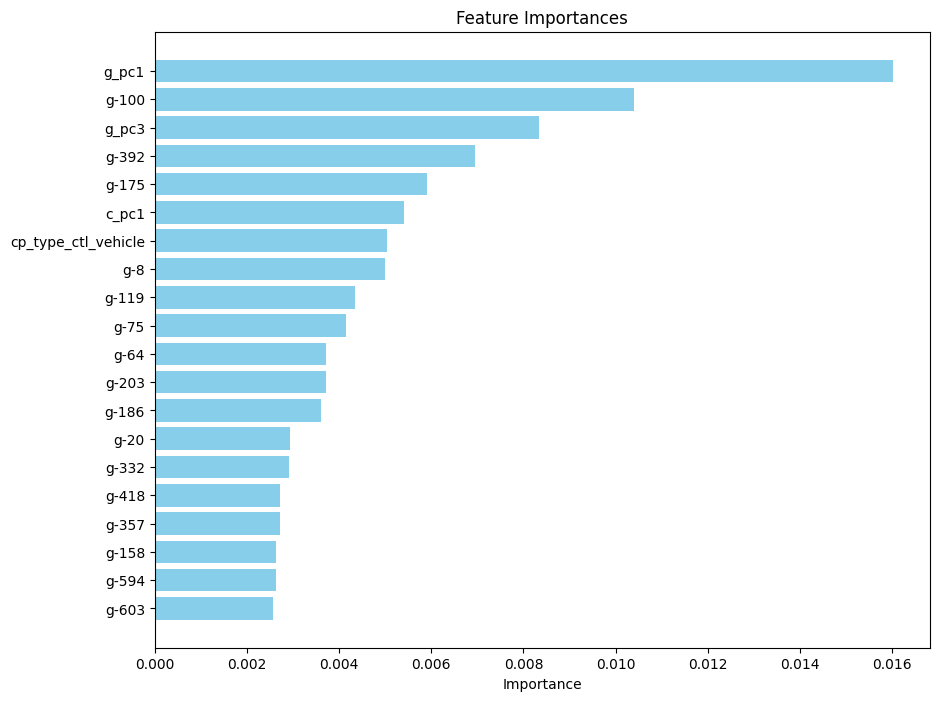

In [25]:
import matplotlib.pyplot as plt

# Initialize an array of zeros with the same length as the feature names
feature_importances = np.zeros(len(feature_columns))

# Loop over each fitted estimator/model
# Loop over each fitted estimator/model
for estimator in model.estimators_:
    # Print shapes
    print("feature_importances shape:", feature_importances.shape)
    print("estimator.feature_importances_ shape:", estimator.feature_importances_.shape)
    # Add the feature importances of the current estimator
    feature_importances += estimator.feature_importances_

# Average the feature importances by the number of estimators
feature_importances /= len(model.estimators_)

# Create a DataFrame for easier visualization
feature_importances_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Select top 20 features for plotting
top_features = feature_importances_df[:20]

plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [26]:
# Separate the DataFrame into continuous and one-hot encoded features
X_continuous = X_test_orig[g_features + c_features+ ['cp_time', 'cp_dose']] 
X_one_hot = X_test_orig[one_hot_features]

# Scale the continuous features
X_continuous_scaled = scaler.transform(X_continuous)

# Combine the scaled continuous features and one-hot encoded features
X_scaled_otest_original = np.concatenate([X_continuous_scaled, X_one_hot], axis=1)

y_pred = model.predict(X_scaled_otest_original)

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

encoded_input = Input(shape=(10,))  # Adjust the dimensionality as needed
decoder_layer1 = autoencoder.layers[-2](encoded_input)
decoder_layer2 = autoencoder.layers[-1](decoder_layer1)
decoder = Model(encoded_input, decoder_layer2)

# Now use the decoder to predict
y_pred_decoded = decoder.predict(y_pred)
y_pred_decoded = np.where(y_pred_decoded > 0.5, 1, 0)

# Now compute the F1 score
score = f1_score(y_test_orig, y_pred_decoded, average='micro')
print('F1 Score:', score)

# Compute accuracy
accuracy = accuracy_score(y_test_orig, y_pred_decoded)
print('Accuracy:', accuracy)

# Compute precision
precision = precision_score(y_test_orig, y_pred_decoded, average='micro')
print('Precision:', precision)

# Compute recall
recall = recall_score(y_test_orig, y_pred_decoded, average='micro')
print('Recall:', recall)

149/149 [==============================] - 0s 676us/step
F1 Score: 0.01726354453627181
Accuracy: 0.0562670585765274
Precision: 0.01248339973439575
Recall: 0.027976190476190477
